# Two-dimensional particle motion simulation_Lennard-Jones potential

Previous 1D and 2D particle motion models used a strong boundary setup (so that particles could not go beyond the restricted boundary after motion) and only repulsive forces existed between particles, which led to the fact that all particles would end up close to the boundary after motion.

This is detrimental to observation when the number of particles is large, numerous particles can easily get confused as they approach the boundary, and such boundary constraints are not real in particle motion. We have therefore adapted our particle motion model to use the lennard-Jones Potential.

## Idea

### Particles motion model

Let us assume that there are 50 particles in the xy plane, and that there is an LJ potential between these particles, and that their interacting forces cause the particles to acquire acceleration, and hence displacement.

### Lennard-Jones potential

In computational chemistry, the Lennard-Jones potential (also termed the LJ potential or 12-6 potential; named for John Lennard-Jones) is an intermolecular pair potential. Out of all the intermolecular potentials, the Lennard-Jones potential is probably the one that has been the most extensively studied. It is considered an archetype model for simple yet realistic intermolecular interactions.

The following are common expressions for LJ potential.

In [1]:
from sympy import *
init_printing
a,b,c,x,y,t = symbols("a b c x y t", real = True)    #Define symbolic variables and specify them as real numbers
i,j,k,m,n = symbols("i j k m n", integer = True)    #Define symbolic variables and specify them as integer numbers
f,g = symbols("f g", function = True)    #Define two function symbol variables

SymPy is a Python library for symbolic computation, allowing symbolic calculations, algebraic operations, solving equations, derivatives, integrals, and other operations.

"init_printing": This is a SymPy function that initialises the printout so that mathematical expressions are presented in an aesthetically pleasing form in the output.

In [11]:
epsilon,sigma,r = symbols("epsilon sigma r", real = True, positive = True)    #Define three symbolic variables and specify them as real and positive numbers
LJ = 4*epsilon*((sigma/r)**12-(sigma/r)**6)

In [12]:
LJ

4*epsilon*(-sigma**6/r**6 + sigma**12/r**12)

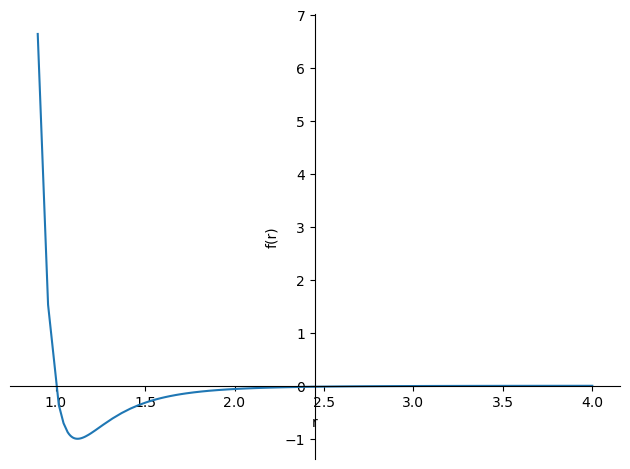

In [13]:
plot(LJ.subs({epsilon:1,sigma:1}),(r,0.9,4))    #Replace the symbols with numerical values and set the range of r to 0.9-4.0.

We can see what the LJ potential energy looks like in the diagram, but this is about potential energy, which we need to translate into a force expression.

In [14]:
-LJ.diff(r)

-4*epsilon*(6*sigma**6/r**7 - 12*sigma**12/r**13)

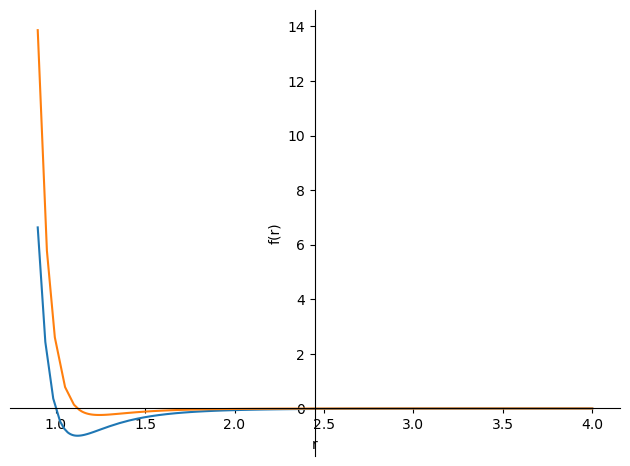

In [15]:
plot(LJ.subs({epsilon:1,sigma:1}),-LJ.diff(r).subs({epsilon:1,sigma:1})/10,(r,0.9,4))

The orange line in the diagram represents the force equation, and we can see that when the potential energy reaches a minimum, the force is 0; when the distance is less than the potential energy minimum, the force is repulsive and tends to 1; and when the distance is greater than the potential energy minimum, the force is attractive and tends to 0.

We can see that the slope is very large when the force is repulsive, so we need to consider this carefully when constructing our model.

This is because in our model we split the complete trajectory of the particle into very many segments, i.e. the displacement at each time Δt is used to construct the trajectory in total time.

When Δt is set too large, the forces at time periods ti and ti+1 are likely to change too much, leading to errors. And when Δt is set too small, this will make the number of iterations too high, affecting efficiency.

We need to observe that the motion range of the particles is between 0-1 in the horizontal and vertical coordinates, so we set epsilon to 1, sigma to 0.1, and set the initial particle positions to have a spacing greater than 0.1 to avoid confusion due to too small a spacing. (figure below)

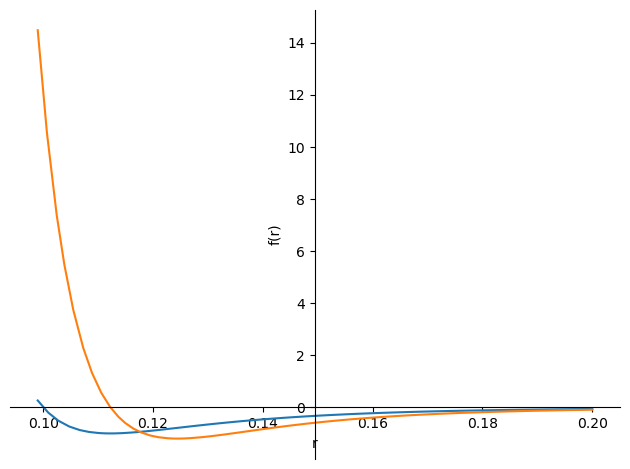

In [20]:
plot(LJ.subs({epsilon:1,sigma:0.1}),-LJ.diff(r).subs({epsilon:1,sigma:0.1})/20,(r,0.099,0.2))

## Details

### Randomly generated particle coordinates¶
We can generate particles randomly using random numbers as usual, but here we also need to make sure that the spacing between the generated particles are all greater than 0.1 to avoid confusion.

In [1]:
def particle_initial_position(n):
    np.random.seed(0)    #So that each time the random number is a fixed value
    p = np.random.rand(n, 2)
    
    #Make the spacing of the initial particles all greater than 0.1 to avoid the confusion that could result
    for i in range(n):
        while True:
            conflict = False
            for j in range(i):
                distance = np.linalg.norm(p[i] - p[j])
                if distance <= 0.1:
                    conflict = True
                    break
            if not conflict:
                break
            p[i] = np.random.rand(2)
    return p

We can see the position of the coordinates of the 50 particles generated.

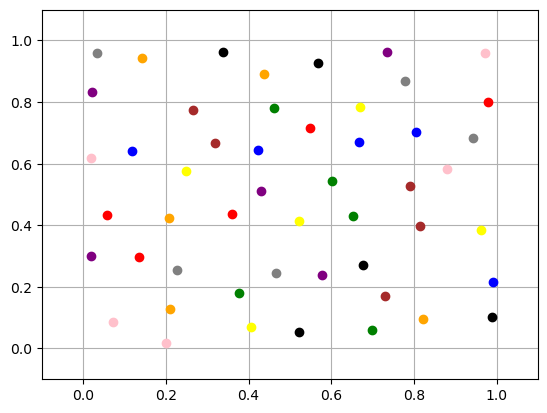

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot(p):

    plt.clf()

    xpos = p[:, 0]
    ypos = p[:, 1]
    
    color = ['red', 'green', 'blue', 'orange', 'yellow', 'brown', 'black', 'pink', 'purple', 'Gray'] 
    N = len(p)
    N_color = len(color)
    for i in range(N):
        plt.plot(xpos[i], ypos[i], "o", color=color[i % N_color])
    plt.xlim(left=-0.1, right=1.1)
    plt.ylim(bottom=-0.1, top=1.1)
    plt.grid()
    plt.draw()

plot(particle_initial_position(50))

### Interaction forces between particles

The interaction forces between the particles are related to the spacing between them and their relationship is given by (LJ potential):
$$f_i(r)=48 \cdot \epsilon \cdot \frac{\sigma^12}{r_i^13} - 24 \cdot \epsilon \cdot \frac{\sigma^6}{r_i^7}$$
r is the distance between two particles, $\epsilon$ and $\sigma$ are constants(1 and 0.1). This means that the further apart the particles are, the less force they have.

But this is only the interaction force between a pair of particles, so we need to calculate the combined force using the 'for loop'.
$$𝐹=𝑓_1+𝑓_2+⋯+𝑓_9$$

According to Newton law, there are two forces. F is the total force of the interaction with all the other particles, the other one is negative friction times velocity (the friction resistance).

$$ma=F-ηv$$
                            
In our simple model, suppose the particle has zero mass, so:

$$ηv=F$$

And with velocity, we can introduce the displacement Δx. This represents the displacement of Δx that the particle will produce after every period of time Δt.

$$v=\frac{dr}{dt}=\frac{F}{η}≈\frac{∆x}{∆t}$$
                        
$$∆x=\frac{F}{η}⋅∆t$$

By calculating the displacements at each time step and accumulating them through a for loop, we can obtain the final time displacements

$$x(t_{i+1} )=x(t_i )+∆x(t_i )$$

So ultimately, we can use this method to figure out how particles move over time.

In [ ]:
# main function,
# "n" is the number of particles,
# "iterations" is the total number of iterations (how many Δt are computed), 
# and "show_plot" controls whether or not to display the particle motion trajectories in the plot.

def simulate_py(n, iterations, show_plot=False): 
    p = particle_initial_position(n)    # Call the initial position of the "n" particles
    
    for _ in range(iterations):    # iterative loop
        fs = np.zeros(shape=(n, 2))  # forces from all other particles
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    r = p[j] - p[i]    #the distance between particles, "r" is a vector.
                    dist = np.sqrt(np.sum(r**2))    #the distance between particles, "dist" is a scalar.
                    
                    # calculate the unit vector, i.e. to obtain the direction of the force
                    with np.errstate(invalid='ignore'):    # ignore cases where the denominator is zero
                        unit_vector_nan = r / dist    
                    unit_vector = np.nan_to_num(unit_vector_nan)
                    
                    # The Lennar-Jones potential's formula on force.(scalar)
                    epsilon = 1    # Parameters in the potential energy equation
                    sigma = 0.1    # Parameters in the potential energy equation
                    with np.errstate(invalid='ignore'): 
                        force_nan = 48 * epsilon * np.power(sigma, 12) / np.power(dist, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(dist, 7)
                    force = np.nan_to_num(force_nan)
                    fs[i] += -force * unit_vector    #Transformation into vectors
        
        # calculating the displacement at time Δt
        x_delta = fs / 1 * 0.00001    # Δt is 0.00001.
        
        # Get the new position of particle "p" after displacement generation
        p = update_position(p, x_delta)
        
        # Plot
        pos = p
        colors = ['red', 'green', 'blue', 'orange']    # Colour the particles in plot
        if show_plot:
            if _ % 50 == 0:
                update_plot(pos,colors)
                
    # plot finally result
    print("P({}): ".format(iterations), p)
    return p



# is used to update the position of the particle.
# "delta_r" is the displacement produced in Δt,
# "p" is the position of the particle,
# "new_p" is the position of the particle after the displacement has occurred

def update_position(p, delta_r):
    new_pos = p + delta_r
    return new_pos

## Full code

In [4]:
import matplotlib.pyplot as plt
import timeit
import numpy as np

# Used to randomly generate the initial positions of "n" particles.
# The horizontal and vertical coordinates of the generated particles are within (0, 2).
# Where a for loop is used to ensure that 
# the distance between particles is greater than 0.1
# to avoid confusion due to particles being too close together.

def particle_initial_position(n):
    np.random.seed(0)    #Make sure that the randomly generated particles are the same each time to make it easy to compare results.
    p = np.random.rand(n, 2) * 2
    
    #Ensure that the distance between particles is greater than 0.1
    for i in range(n):
        while True:
            conflict = False
            for j in range(i):
                distance = np.linalg.norm(p[i] - p[j])
                if distance <= 0.1:
                    conflict = True
                    break
            if not conflict:
                break
            p[i] = np.random.rand(2) * 2
    return p



# main function,
# "n" is the number of particles,
# "iterations" is the total number of iterations (how many Δt are computed), 
# and "show_plot" controls whether or not to display the particle motion trajectories in the plot.

def simulate_py(n, iterations, show_plot=False): 
    p = particle_initial_position(n)    # Call the initial position of the "n" particles
    
    for _ in range(iterations):    # iterative loop
        fs = np.zeros(shape=(n, 2))  # forces from all other particles
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    r = p[j] - p[i]    #the distance between particles, "r" is a vector.
                    dist = np.sqrt(np.sum(r**2))    #the distance between particles, "dist" is a scalar.
                    
                    # calculate the unit vector, i.e. to obtain the direction of the force
                    with np.errstate(invalid='ignore'):    # ignore cases where the denominator is zero
                        unit_vector_nan = r / dist    
                    unit_vector = np.nan_to_num(unit_vector_nan)
                    
                    # The Lennar-Jones potential's formula on force.(scalar)
                    epsilon = 1    # Parameters in the potential energy equation
                    sigma = 0.1    # Parameters in the potential energy equation
                    with np.errstate(invalid='ignore'): 
                        force_nan = 48 * epsilon * np.power(sigma, 12) / np.power(dist, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(dist, 7)
                    force = np.nan_to_num(force_nan)
                    fs[i] += -force * unit_vector    #Transformation into vectors
        
        # calculating the displacement at time Δt
        x_delta = fs / 1 * 0.00001    # Δt is 0.00001.
        
        # Get the new position of particle "p" after displacement generation
        p = update_position(p, x_delta)
        
        # Plot
        pos = p
        colors = ['red', 'green', 'blue', 'orange']    # Colour the particles in plot
        if show_plot:
            if _ % 50 == 0:
                update_plot(pos,colors)
                
    # plot finally result
    print("P({}): ".format(iterations), p)
    return p



# is used to update the position of the particle.
# "delta_r" is the displacement produced in Δt,
# "p" is the position of the particle,
# "new_p" is the position of the particle after the displacement has occurred

def update_position(p, delta_r):
    new_pos = p + delta_r
    return new_pos



# for plot particles
def update_plot(pos,color):
    plt.clf()
    xpos = pos[:, 0]
    ypos = pos[:, 1]
    N = len(pos)
    N_color = len(color)
    for i in range(N):
        plt.plot(xpos[i], ypos[i], "o", color=color[i % N_color])
    plt.xlim(left=-0.1, right=2.1)
    plt.ylim(bottom=-0.1, top=2.1)
    plt.grid()
    plt.draw()
    plt.pause(0.0001)

In [ ]:
%matplotlib
simulate_py(50, 1000, show_plot=True)